In [35]:
import pygmt
import os
import io   
import netCDF4
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import colorbar, colors
from global_land_mask import globe
from scipy import stats

In [54]:
def random_points(deposit_data, n):
    '''
    Generate n CDFs of random points, each the same size as the deposit data.
    '''   
    arrrandom = np.empty((0, 2))
    arronshore = np.empty((0, 2))
    arroffshore = np.empty((0, 2))
    
    while len(arronshore) < len(deposit_data) * n:
        lons = random.uniform(-180, 180)
        lats = random.uniform(-90, 90)
        print(lons, lats)
        arrrandom = np.append(arrrandom, np.array([[lons, lats]]), axis = 0)
        if globe.is_land(lats, lons) == True:
            arronshore = np.append(arronshore, np.array([[lons, lats]]), axis = 0)
        else:
            arroffshore = np.append(arroffshore, np.array([[lons, lats]]), axis = 0)
    return arrrandom, arronshore, arroffshore


def get_cdf(data):
    '''
    Calculate cumulative distribution function (CDF) and probability density function (PDF) for a set of data.
    '''
    count, bins_count = np.histogram(data, bins = np.arange(0, max(data), 10))
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return cdf, pdf, bins_count


def get_std(data):
    '''
    Calculate standard deviation for a set of data. 
    '''
    sort_dist = np.sort(data)
    bins = np.arange(0, max(sort_dist), 10)
    digit = np.digitize(sort_dist, bins)
    
    std_random = np.empty((0))
    
    for i in range(1, len(bins) + 1):
        std_random = np.append(std_random, np.std(sort_dist[np.where(digit == i)[0]])) 
    
    return std_random


def neg_d(data1, data2):
    '''
    Determines if the maximum displacement between data1 and data2 is negative.
    '''
    data1_sort = np.sort(data1)
    data2_sort = np.sort(data2)
    d = 0
    for i in range(len(data1)):
        if abs(data1_sort[i] - data2_sort[i]) > abs(d):
            d = data1_sort[i] - data2_sort[i]
    if d < 0:
        return True
    else: 
        return False
    
    
def ks2(data1, data2, n):
    '''
    2-sample Kolmogorov-Smirnov test comparing data1 to multiple data2 CDFs. 
    data1: Data CDF
    data2: n number of CDFs of random locations
    '''
    d = np.empty((0))
    p = np.empty((0))
    lower = 0
    upper = int(len(data2) / n)
    for i in range(n):
        d_ks = stats.ks_2samp(data1, data2[lower:upper])[0]
        p_ks = stats.ks_2samp(data1, data2[lower:upper])[1]
        p = np.append(p, p_ks)
        d = np.append(d, d_ks)
#         if neg_d(data1, data2[lower:upper]) == True:
#             d = np.append(d, -d_ks)
#         else:
#             d = np.append(d, d_ks)
        lower += int(len(data2) / n)
        upper += int(len(data2) / n)
    return np.array([d, p])


def plot_cdf(data_deposit, data_random, std_random, ax, title, z):
    ax.axvline(x = z, color = "black", linestyle = "-.")
    ax.plot(data_deposit[2][0:-1], 100 * data_deposit[0], color = "C1", 
            label = "Raw number of data points")
    ax.plot(data_random[2][0: -1], 100 * data_random[0], color = "black", 
            label = "Random continental locations (mean)")
    ax.plot(data_random[2][0: -1], 100 * data_random[0] + std_random[0:-1], color = "gray",
              label = "Random continental locations (standard dev.)")
    ax.plot(data_random[2][0: -1], 100 * data_random[0] - std_random[0:-1], color = "gray")
    ax.fill_between(data_random[2][0: -1], 
                    100 * data_random[0] + std_random[0:-1], 
                    100 * data_random[0] - std_random[0:-1], 
                    color='silver', alpha=0.5)
    ax.set_xlabel("Distance from " + str(z) + " LAB contour (km)", labelpad = 10)
    ax.set_ylabel("Cumulative Frequency (%)")
    ax.legend(loc = 'lower right', prop={'size': 8})
    ax.set_xlim([0, 1400])
    ax.set_ylim([0, 100])
    ax.set_title(title)
    
    return ax
    
    
def plot_hist_d(data, ax):
    ax.hist(data, bins = np.arange(round(min(data), 2) - 0.01, round(max(data), 2) + 0.01, 0.01), 
            color = "black", edgecolor = "white", linewidth = 1.2)
    ax.annotate(str(round(np.mean(data), 2)) + u"\u00B1" + str(round(np.std(data), 2)), 
                xy=(.96, .94), xycoords='axes fraction', ha='right', va='top', fontsize = 8, weight = 'bold')
    ax.set_xlabel('D-value', labelpad = 10)
    ax.set_ylabel('Count')
    
    return ax


def plot_violin_p(data, ax):
    ax.violinplot(data, vert = False)
    plt.gca().invert_xaxis()
    ax.set_xlabel('p-value', labelpad = 10)
    

In [37]:
# import data

# Get current working directory
cwd = os.getcwd() 

# Lithosphere-asthenosphere boundary (LAB) maps
sl13 = netCDF4.Dataset(cwd+"\SL2013sv.nc", 'r') 
a06 = netCDF4.Dataset(cwd+"\A2006_lithosphere.grd", 'r')
litho = netCDF4.Dataset(cwd+"\LAB_litho1.0.grd", 'r')
afonso = netCDF4.Dataset(r"C:\Users\edgar\OneDrive\Documents\2022\Honours\Data\afonso_2019_LAB_0.25d.grd", 'r')

# Global locations of magmatic nickel deposits
mni = pd.read_csv("mag_Ni_karol_181117.csv")

In [38]:
# Sort deposit data into array of arrays

size_mni = (len(mni), 4)
data_mni = np.empty(size_mni)

data_mni[..., 0] = mni['Longitude']
data_mni[..., 1] = mni['Latitude']
data_mni[..., 2] = mni['Age_Ga']
data_mni[..., 3] = mni['Global_Ni_metal_Mt']

In [39]:
# Generate 100 CDFs of random locations

random.seed(999)

random_mni = random_points(data_mni, 100)

onshore_mni = random_mni[1]
offshore_mni = random_mni[2]
random_mni = random_mni[0]

101.2848785845307 -75.58818935333397
134.09729871454363 13.275937557714144
-3.3999105243483143 -66.22719676736756
107.5189813454644 -32.738821090251776
106.02337085700873 62.125165369074665
-144.93125801983064 88.98778640301586
-112.3189290337461 -42.374916706618876
25.537998818847512 36.3783754430295
-88.66619271562203 68.49062532981876
174.79055450667818 -49.187403246358556
47.267181164301746 -76.5247491854169
-171.53781305140512 -53.96892118763461
169.18904240653666 0.0443371945175528
-112.93091063634168 31.507023271412066
-120.63022355661144 69.30449914607445
18.63695351838723 76.26219695162197
-12.153408511476016 35.33442101422435
88.00646523036954 -66.652922637706
55.262167899892944 -6.308906952710828
89.57366838920507 -46.270396126634104
-139.90205958415268 61.68120054712756
-96.80752318022793 53.126031019066204
-81.32988046081736 0.2707225395644315
-164.78365951648698 49.15190554839779
-16.696585314075406 -70.36842616836663
148.91288265875676 9.587968906609376
-118.224356506599

-74.50775412920898 -22.70445978785645
178.43011404697074 18.144032769347263
79.06860805423281 12.878672149506514
146.70933708566383 -24.27759992266124
154.30253961462194 -65.41324900479495
-47.419423883543686 -61.487676437782504
96.15956863324334 23.818890440065104
94.03199523882273 -1.1617267666014328
-99.9115998890031 67.31679520670446
82.71682761602642 34.04048336294687
-66.22011869258453 -41.80267811448664
-114.94205877837554 75.21907333542009
-27.308113189162555 -85.9735125011765
136.73558199566975 68.03224618447604
33.332400108494795 -48.41799943616315
171.56921168990533 72.70188211267885
-179.59835017974342 -82.14739721374998
-89.77857065782754 -72.0971561249066
-22.046144969407663 30.477719604074835
14.913613519639881 -64.47379414588531
47.10713208042074 46.60285922757677
68.05685104854948 33.17619943594937
-174.76062317805628 -70.33237649570916
-161.39888472806157 26.81340560591245
-172.79655903957797 63.007047153790865
58.792933882070514 -21.809703348988634
178.9925459939526 

125.89733088597148 45.47735901009787
-42.623644494740034 -22.438366916039683
30.984790269027854 20.32615304716782
122.38103052715837 28.57035240609035
28.522640733928284 -71.52660205869103
120.35788160645473 22.15938651984702
-66.15007755194617 42.68906084172605
-118.98652029265057 -73.1352159575221
-178.189698326448 -69.37573020676706
138.81473379091523 -22.811629357377072
73.75215263038464 43.701685834266584
31.35260449674459 69.23739745462296
161.63483059004176 -3.2173082119916074
-48.09352831531501 -31.587836997528186
43.248450219672804 5.693447587131004
-80.17055167370052 -69.62791975816735
178.1906109911185 -38.369928462937395
-63.62484454039017 42.56591228655614
-34.0671373276509 -76.80382994500667
60.573519434213864 4.828559668853913
140.17786323221083 -7.264659592405806
105.39843248435727 50.604768504032705
133.5621348618834 24.75809208263088
150.02833514441699 45.58532706260061
-121.74392695651198 -2.1992121781083966
-78.09529833860948 1.5552049901079812
-42.938949784448056 6

-31.985927730650417 -26.46062358327616
-125.01913481334245 -62.48492058024339
31.0154279764553 -74.01853192668196
-27.707949972558367 -17.973212632181983
-49.25295329427425 -16.28339975941803
-117.82682070641422 64.24492085538716
-161.58465652463136 -34.89598845660048
67.98353658275948 80.54434136809212
44.725947339435976 -18.429568546209623
93.5717232836405 -9.41176539504987
-155.04697952815505 12.722809756312827
14.945327401859089 -1.2225921285213843
53.43231355276737 -45.74980928586361
90.0860173160728 20.730635883547933
112.39656835315344 -1.3013251083479958
160.1824652443272 -25.921400179696676
173.50476090461189 1.3043414680037841
-75.34888211245897 36.449730441089585
114.89419320538144 -70.39834339435319
-7.006538763859709 80.52212197285141
-155.13943595557186 70.05981012008436
140.76450825635146 -52.47201436147848
-165.14810847145955 16.430908641386196
84.0209605359147 -76.71371352789363
-41.04500265550399 -56.00108338768065
102.41214652128787 -13.940909668680902
-113.665506384

33.472821369629855 2.5903714889463316
-38.771772193334925 88.08700758114813
72.3608386028242 12.733479442991452
164.17223658750163 -88.22949839338123
84.39114867516298 5.750964246324969
60.97086089285915 20.310860383314534
-149.02248829777594 49.94257335314032
82.77137034080602 -57.330258288168956
-88.17071890930512 -59.38470246867202
-160.60211806352285 51.758837106273205
156.85209898263525 -12.928591632614939
11.549073923279508 86.01484861527399
-121.42670229984145 -39.63759173405699
17.2646136305886 22.63233075192248
-64.63581839971278 -34.373501501841396
61.87641034273264 -46.95498118468709
-17.121770266988477 -89.43836169919729
88.64137441420576 -41.608163530042646
146.02852531007233 -11.27298194825623
136.30830811549254 -24.516037482024544
169.71420851111776 3.4636488978269
149.8822324215538 12.415613805288999
-129.40854662952685 -41.404079027631184
52.8870713849214 70.84066291614525
-35.404706540736356 12.60547378081121
-34.168934239729026 -81.76271496406422
3.738816615190103 -3

-29.74685287409625 -36.68455559988913
138.60591624132655 -88.00737384482183
-60.0762517675371 57.568103227578035
-176.32208172852467 39.06135401560729
-13.26874217234814 47.46080506105366
-44.287057523575385 43.156441679657206
-136.21617279473637 77.95169063797715
36.68502629981015 76.18642289604284
-126.34421555841729 29.508010566751864
-67.51620093100773 36.37271416577566
92.1679578453734 53.38701402015096
54.188404405924274 -58.538318385038934
111.97304965976235 -11.073756928076904
-30.324872774636532 -13.963573432821391
-56.35840870600107 -71.82206922962247
112.00705933161697 -49.92341263568945
-157.66949776639868 58.832973733344176
-63.10607902782803 -0.9784089689362077
-160.54436372732812 -69.77540683249839
131.9404158448574 -34.419995039215166
-116.37705235986542 -31.410896190097652
-122.35919378509973 4.052486279687571
164.61111202968266 39.549223730418305
-122.58750729312368 -63.53022292542545
-127.58909722925299 -58.653162050395935
4.0544360204280565 -48.46014494428296
34.819

-154.73227809016754 31.71830462240034
-65.2391291475772 81.4759657210748
-85.96021642191107 20.284234680982323
-24.202777480507564 -35.46350450631054
107.1872385674314 -22.119539892734394
-34.59136210788631 15.269762953737484
145.6029372840693 4.81714354924685
-69.39043677572134 -66.79144594487656
174.68961595155292 86.92760442556616
-65.05260986373139 73.840405331022
-169.8130237653495 -14.764278895026848
81.83756343241458 -85.7032605889946
110.38975262980614 -55.412703235751856
-18.646125696658885 -81.21675429588574
168.8496237865442 82.91379030455121
4.240737987843687 12.68664060612302
115.35890931158195 45.966341562743565
-63.457975236298324 -39.36919797467566
61.747674779266134 50.92983116438526
125.70892756525751 -77.84264604629361
-126.57949167718547 84.70515785434281
-13.225974214248026 -24.686103797842108
-166.25836171493916 -10.690414552499178
27.38337639305729 65.99714564535711
-76.0569302876564 63.34415776300264
-124.39334638426868 59.91710698916049
162.88871172333648 -38.4

-58.905416017960164 -37.999144825943574
129.29957058560734 -88.92446369433799
59.198350935905495 -21.80615035490881
82.07060159168111 59.33003135003048
111.62419489861963 53.61725690169044
-177.72004867895876 -80.05866700823545
-157.7468239719911 -13.906470763504089
159.26475308615915 -8.859318957757836
-127.14951239384209 45.294813222770955
-29.708274827434025 5.454371444377728
-151.31821767647935 83.81656157403975
34.63699245055122 -79.32199129073328
155.91002694581425 30.68372114215458
-35.69075322345739 -29.858035828533346
139.65736067075198 -52.53461109997156
149.96680130096803 -86.53140703585397
115.62638404770291 0.38082655674713806
-129.44674140651927 -48.76149564354866
104.9711518055268 -20.91296729023918
44.828508539252255 28.52614162623533
75.05316686147191 -21.648954583950285
30.408770583858654 54.69116265081101
117.24701916929757 -51.67347172624898
16.83794356769505 -53.90662073094605
26.147909452244193 -22.201148177077712
-37.89730184579659 -39.54825966783927
141.47639132

-104.25163352564215 -23.732747564220205
-169.42136005522838 44.588136868258346
-4.477545494754992 -32.038415710907515
-88.53696039576879 -8.570647791716539
-157.92053651885374 72.33683241745359
100.32114328575568 -22.342188452963825
-85.20701859243513 -79.7394010077888
-4.632478544739087 -18.622592325941994
22.86625788885368 27.034789149549937
-160.3169639097622 11.469561722327555
178.79563035261862 29.862032226794568
-145.0114109171247 -45.6902945957504
76.86358498871948 -48.09830089861236
-131.42392388571818 81.58990727755696
-66.74810687135331 -6.433267885112485
82.7192511775458 19.985996242265358
67.87891677280587 -56.31125757829631
-55.25069057510679 55.088479403020216
-166.37983942068902 -4.235915997364302
-75.8600077226779 77.96902557683174
39.970482216939246 -48.310488252154705
-111.1189443873377 48.51113241015551
17.930425127140722 -82.78762188871943
-18.132938982149312 64.84838524356093
-138.93971863675932 51.88178663872341
5.869136130589368 -53.92930796866749
-31.47371411376

-109.72907306659748 -60.39410230281159
-166.59160357859486 -60.400527842078674
108.88015065992346 -42.960723604741034
-106.06145708558873 -59.49703242876358
73.7733531343608 -70.25998574345927
-20.694799852911302 -77.3048920742529
-162.23204633923154 -39.729103668336776
-176.8876863370756 -58.56341290725493
-53.94614745556058 50.911604433751535
-114.73690000383108 -22.575077776875915
-83.37849922688706 -27.998973737399837
5.064755237088065 22.229553887090503
-39.38210826777001 27.479544381683382
142.63964719075142 -57.889128711275546
121.31915914994926 3.1266180928025733
147.96696727358153 17.221148122452874
69.6474747912205 41.99892894782033
-141.25196967274996 -81.4298702700797
-80.44405999643469 -15.115332771982992
-138.7212574956518 -81.13046286917665
178.45933140080615 -81.76465107875208
50.01688611130706 21.52132313208635
-141.5256625313596 -44.91125117910084
-9.481780829188267 -32.862601722241294
172.5668188558172 14.033343058834689
-122.87705998989452 -37.44737623422925
173.981

-121.04927006635964 -53.60789509963672
-132.92380789001476 -56.749296990699364
-54.44606616961792 -12.213144490214802
93.68908684934678 -64.51954789591186
36.725633009457596 58.677157657954666
90.49960211856143 -51.00998233923975
-81.73692647326932 42.35749818707791
164.44819941718214 -62.27013568676807
-21.46278035494049 1.1399453463851472
-74.06818805851071 81.07259914107973
-79.56711942165968 -85.7919155510915
57.22891715787014 -89.27080762622558
82.4755808752206 -41.879122178721374
-150.4015086460636 0.9512837611382565
-74.24367945089544 64.89788860211809
-95.15370534215471 -69.76836769258776
-153.75248716415325 -31.078771311051128
61.278704834349014 9.503728123156847
130.4967571664409 -76.51455931898347
50.373725899536424 -19.298206798125975
89.79801248660368 -60.51651061889511
-55.719439880160095 83.32285892979473
157.9792560585347 -51.29492094435796
49.724392416708184 -23.34341613708328
149.9439518458429 -77.98509175257706
133.24722795119362 6.487435264807971
134.81138648350213 

108.07213018601249 47.77548190500133
72.07095321512372 -20.29482576421333
-112.31921770297355 11.500724718106085
53.725569684258375 -66.73979369381858
80.28271440911135 78.1077646275632
116.02746764690386 17.065429698487577
-52.265005736080965 -74.79873209731086
-105.18009435753919 -66.4024374283517
-5.4604623931367655 -81.38578702936002
130.4103216357787 -19.279004134707165
150.7274390373891 -27.985995030376074
-134.05899402482333 -3.2966551568877662
32.09031495533932 47.658468955909115
78.96239355234002 79.0716875920055
-159.91747142834365 -62.13741336842747
-44.4277352336982 21.10477601771774
-18.850178553827305 -43.318103179316545
99.80941020128842 75.68674650844252
-164.74937078855535 -16.747653052161866
98.97934462359382 71.21210265925455
47.37161259565022 50.76377543027658
110.49749624048923 83.3606116677989
-177.8286642314264 -58.211967750509665
143.80245785064437 -13.602358119586768
81.44444757377573 -18.375403955742527
-80.22286745749541 -19.64471463877237
130.43829769644157 

-58.02018218361144 5.834192959598724
-31.247908452911332 81.49596519825758
-94.63747634333426 -8.908443174604457
172.5874806237208 8.996097796745701
166.8090686547775 22.42378745010474
65.58355983843657 -81.15983340027663
138.68476921416254 13.01913555604888
-172.7176440156437 -38.046694575349704
-116.23266778726838 42.279025600542695
152.96950538932134 73.39429594849065
-172.9044052054894 33.498237132077676
53.30976461335342 -68.50182837405114
-26.792864750438184 2.883687972568495
-162.09121175436223 -49.69770246669223
-136.637783120269 -37.41216988689304
138.10663162360777 19.023798439903942
6.328101280904434 33.66802433684158
65.34037305493433 -61.63635528934954
-22.281179771246343 -57.541208808261146
-177.07302290345783 -50.314031666262295
-76.97198613878292 77.8282110981022
116.06813594893265 -48.35904475032243
-128.34708720471266 56.450813078176566
125.00151372116284 3.3450730339845762
-96.42314279969798 -53.495052152047535
110.25285133058998 21.808218552390827
-17.93360919825738

20.450943126656654 58.245463757986414
-39.228175946848495 -27.04344870726461
-113.84631403341466 57.89084395768646
93.13251772491839 35.073165766199324
120.3026250375795 -54.85488658698096
155.7432878498908 60.73813512624059
-158.33292651375618 -87.16146192677871
22.342932017413972 52.301217503236586
-77.44705894764914 -15.359696469351093
-87.11323626227421 -61.5031789934809
-170.49084683006896 62.762732540949656
40.288237743467846 -63.62057730367667
76.2040635640351 85.47181386238717
-73.58112818564437 -79.67886517777791
-107.71160349308434 24.727551989513444
-98.83612607352786 -44.53597317403742
-112.00989820300116 -16.893385974477383
68.11333482805213 14.967780472670597
-89.13992454690307 13.707528163191668
109.9661302080392 32.636388870883835
159.58033428588863 37.72789644769763
156.4304189883402 -71.38740643233709
22.06487850778518 -88.83591114197243
81.11336196656856 -19.19531146044946
-71.77735782108796 -51.35410658351669
-134.37175767565745 -0.912128706571707
171.96028259737614

-136.6309067455724 43.763782431230766
-65.3942640877728 13.033392366714494
97.46099924976494 -49.51584221006048
-42.20394448597534 -44.31744240466145
109.53794071883158 41.233693270744084
-142.20192802990277 21.990922210256656
-2.014771434486022 70.32780908473262
152.38687516699497 -86.80271408643732
-129.35412743946716 59.844044762626055
-129.67160259091696 -38.703443947592504
57.673879208532355 -50.26517883472129
-36.14345493882482 -88.18342587791632
-138.57064427561127 44.222426001930444
103.50444446117655 84.4885346315798
-167.80238524401355 -37.892550953780756
-67.18189855619676 65.03385191264718
16.49388800307949 -39.3051038583
-24.96051484653057 23.791806359938363
-109.35914362500354 44.03945013297192
-128.92232536307583 -48.017331454468035
8.003366423122998 53.47756756396305
28.964378965110484 -74.80832482261262
161.4262824686137 -27.227371546106674
111.6079174188448 -70.04824720862923
-56.44106348500338 -87.96029617596629
126.2873422514021 -72.44379473536864
-32.35971854581012

-141.2564263833058 -79.14736639919894
160.09079745379802 -47.620186697231674
179.16699487154222 48.128169184200885
-157.4250237892542 -11.800872742504012
125.72431303077559 38.49305250816869
7.9082817436149355 -25.200109493888036
169.63935647664368 -16.05454377185434
105.38320622466495 53.369959496564206
26.50296071359176 41.37111026350016
-82.24723216159896 -7.271615370019575
-152.1558683463021 -38.69613154891027
-95.24676491249701 30.887501595574406
-51.30879615959381 -28.00349872040715
-42.99968099258919 59.86381538738701
-103.41489486934577 -57.46160424747885
132.28783342606835 -13.530560484038133
85.61192218620891 -86.04692567031321
122.91627665299643 -49.59063911666605
-128.23850610383843 53.32359638946505
-134.14200577494051 -67.30993903162957
-174.23858408458452 83.85870024317839
120.54670766789138 -8.727713569111131
42.3996893721052 7.604282611823393
-159.28351057031333 26.185084712104114
-24.08873265159508 22.86823045893837
-38.91583673846844 -36.99996240943243
-13.5774264409

4.299315601068372 -68.35106469397508
154.05311577884635 62.53272447579806
83.53505043219593 -53.93018934170434
-126.43340018886968 -86.9583620558576
-177.84049886231242 19.50063460995227
-27.53340559456541 -77.48442528567105
-27.27179422993774 -30.976620007328812
116.22712398614937 -71.75155534711702
-161.23834165785377 -49.31089702992668
62.61904195329211 26.45669540397232
-99.83209622546482 84.86844720173877
-114.48647565253054 -48.41407078291395
-139.09532644648255 -60.67729135230475
-75.61433499888915 -77.80812513539743
63.61749834152991 -57.70074499862908
100.46408896440403 89.90370064753404
-115.0168344146079 73.48695973020386
-111.6847713645598 -66.4339625173271
-48.3740195723085 -70.6760672043263
176.52333651557268 -11.955914889346346
-75.32359440834311 26.303566641713346
6.752931748990875 69.36410196213563
-117.7665290213746 -71.13987690816043
178.1445954748088 -13.6625906540623
-120.0444183498842 30.958832852134393
-122.03879742416163 -38.475796143238114
28.95397851623656 -46

-91.82488025102795 -55.78468092842229
-162.62997222561887 -21.204673604146322
-55.78059407543009 -54.43087302615088
-144.0493957372526 -76.04675126128049
-121.62414708486862 53.46502282651156
-63.20438839301934 53.54563845239821
95.56961385190885 6.911994362299765
158.95418711318223 62.10901054104809
-133.60699783675076 -67.22276738834228
-158.32664672142351 -65.24863413333156
-71.27337624961449 3.19295103047871
-66.85180313770996 2.0341920159250577
166.13314914927946 37.623530119414625
170.21525228632402 -74.51542350357168
-165.49512288628765 47.93451045617687
-149.2081873307561 85.08086579512133
-147.29406689799077 -28.474777365104913
144.97102318587895 19.622163955331118
-179.62211301633818 38.28452702393537
-160.29622106206247 51.40424518077347
-114.1477470748109 -28.741661153288298
131.96788717392513 -21.96850165727983
123.47812270223272 -4.416665302549845
-27.153786041660112 -19.22707171848711
175.96402490378267 -51.04469922643728
-136.08811310896633 35.142601568878476
95.0636168

-152.35615875111242 9.065855384502825
30.24071424413154 -10.719809154210438
95.59596943584222 56.11797567012397
-31.963424430991438 0.03518394806273761
41.23656035624629 79.67730142982103
-28.427828230064677 15.433679026541142
-6.367401181155003 83.81453658322181
93.54271592106215 39.665803411648426
72.11981372056644 -20.720768041150208
-170.2020615731493 33.94023098877692
141.53204761622038 48.931866910591935
-70.77832405161774 -28.915085544807276
9.164907412748704 -31.383149168002753
-53.790554195227855 -8.877653171637405
56.811175388081125 -54.97408989933883
97.95753149221883 14.117664685252052
-19.082209331632328 -84.70379834282174
-94.75515634225192 72.87799807996365
-30.54247804736002 28.86920496737845
174.73333627036783 41.019111076896166
46.5382908468699 33.57735665441905
-78.90112163421665 41.748465955947324
143.4277791756112 -19.60037263036361
139.26065146466715 -68.25764983572483
138.83821060104634 75.78374141719232
39.86395641537294 66.97731667171129
120.59663878597661 41.5

-6.187071596368838 75.54428467563605
4.704878013731957 -10.681983366922623
-7.593749578870131 -47.430805045208466
-55.03388250593119 75.93744143527744
-112.68300668024831 -35.14934988220874
10.022935497402159 -7.460050872522231
-113.82042947911097 -44.72241469725633
-107.43909306488462 -59.636717861268124
-33.15243773874454 63.71022666836183
-166.19163684956519 -65.004604245471
132.97424509003355 70.5907066756501
19.699205568347708 -22.94251626852595
53.17448087200185 -40.10204101328048
97.12017264412674 15.52549148221712
98.32741617595718 -14.326796773281615
56.59827655792432 -5.216016629867283
-7.2175152147318045 6.214669822969626
134.90015808054494 69.33704634759084
50.654922123634236 -48.580066892515596
83.35818774208678 -77.25258929543389
141.08266343673785 61.11515112774151
124.98116874005433 -5.910597696974662
24.405362929286383 43.03840983221801
34.63723976792042 41.03369024776637
82.95738047766076 -77.1597504493989
-81.01661568379951 5.7867519213292695
-139.89020043916918 -22.

-135.74599118464792 22.23902076849771
-137.43969269007573 79.07600981063175
15.295614036262691 -29.708116159851457
-75.33187498605884 6.961644769317232
-34.97577409843419 -47.364580461359516
46.6397708410301 -24.873707442056656
-30.259767396035897 -14.292774846794018
-27.779325859911978 45.932871806944235
65.32193501016337 -21.414163341997266
42.11935358728289 -16.77375781971506
-49.178795407562376 68.69838241598774
-96.46711307652527 -62.55539525242081
82.47576723994752 -55.32136173749499
102.15698215473833 0.2584720927784758
133.66814179737173 -56.932028130741905
-145.63739043363276 51.233761480572156
-87.9215084432209 27.078655757174218
-99.78074695099657 -85.94889584617741
104.65663818589485 -42.382185169633345
36.57840010388122 -27.840937895986983
-92.25982514974842 46.21907010869012
-10.765753847645726 -81.52117867197506
-91.52498575764974 -9.575579155206597
120.03452268705894 -82.57954731793086
-79.16903990401832 46.7726688814179
158.52498039789782 -11.009802368836318
82.3632531

-25.92503829230563 67.07562327873458
149.26813713132998 -54.86984532580544
-177.3603208716537 -69.6429674075852
61.469729695656724 -22.709230842048925
61.72678126601136 63.3201107419128
-5.0121947127879025 -46.47254634260677
-24.06428756368635 20.67314252703092
54.27933676834701 1.4114316828767812
-167.4989930860916 43.94979521049572
-9.179225148781853 -15.74921013526135
74.53884689244762 -72.06411511729218
101.7690993992017 -40.93940080701521
18.15951375931587 65.94545621298329
-83.89684519220165 -8.132275988842395
-21.234227840009396 -7.289897804410899
102.47184939733393 73.66352337335357
24.100415022524544 -83.13140495580895
-172.2957560749275 84.20528173365858
15.5422517891069 66.09280766755941
-99.9883650915649 -46.05237844972222
-31.488608145784212 -67.57194751143957
20.942369742824184 -78.14243744307475
-14.072301182038899 46.06410451866611
37.698684475642835 51.277420777471434
30.740641152738192 -62.52349667555571
58.19512273369031 1.5915163525117038
61.332574440691644 -1.38287

-41.268017620525 -3.09276855253448
-161.679562527997 -50.84033808709423
61.05859260646051 -25.1686248661658
3.1210576615032437 68.08521949845615
45.96621650221928 -44.16723987552922
167.18274880807473 42.882189151350616
-39.57035297250326 -69.24241009179492
28.25447329470049 -1.2475304019480973
-68.02618688383306 -3.2074206494533826
71.41658953195301 85.09053072435395
-153.6377441732997 -29.529058520350752
-109.25312428944036 -82.87294933737452
98.13464972365455 64.78518915467143
168.3281102564565 -76.69512082618917
-60.08322205022493 -50.908278918161265
-74.85222283465413 68.80609778518814
-130.49560421078297 -2.524958877695454
129.0309687169816 57.74381692729327
-89.83112888407587 14.62044320102406
63.69273896396234 -0.6155259338979704
-170.49326710454892 88.04163297468583
51.64601913845658 -30.738909428616267
94.19378135658451 -2.4041265618794228
-99.61600140968797 -48.49309831640818
80.25040534070166 -87.42381253322829
-0.6590703733363057 86.71283024139854
-17.919299830319886 80.10

59.6289674852062 -6.146140422801025
141.73947577937486 16.287594150438352
106.8715706040457 -39.959707701309185
-144.51473512864314 19.709619292692523
31.821867548479048 51.057483462825985
-60.94326173424729 -76.20845577473283
131.27827599327173 -15.464548760545156
-30.74004464445275 -52.24405531153035
-16.53557957218962 50.647905872729126
-157.17651964356293 50.47114205515658
-130.425576693345 85.9593224064304
24.252781213819247 -0.7581557545911153
82.68581377311955 25.07978410640554
51.126521308111876 13.821810738027295
-137.6738289535703 -61.457639097589734
-92.00381192131799 -64.53435339120595
117.67302098807039 -82.447056890135
-153.16655247488598 41.20992703295124
33.95050133737374 -8.989483683114216
-25.418501807326834 -15.483267605373669
130.77318754532683 -29.174462206619317
-96.29670260603739 88.37656120278706
21.641789795052205 41.137329348791354
-6.11779044929861 39.197555594621235
17.778150294671917 39.80856461167926
-175.6826994489821 -26.199726606589465
165.770632631352 

27.876798808531362 16.947163825754288
151.47082579032747 -74.68748788818203
66.52455059149213 -60.4169990353804
-13.215589564496554 39.10058693877778
-138.89957309508827 18.381514847741173
101.91688320269026 1.7084050796153747
90.30721932196599 -63.27992455067398
5.804526665824966 -22.376775772687694
144.8843505334347 -66.39692390583267
-58.070328849165676 -29.50678437170712
112.72419567276478 87.99074343146563
-121.32418510243292 -8.948719971713857
-175.6073857693772 15.164854540821423
-146.9875244917834 -18.626486357701708
89.18990429003247 26.044834386201003
31.652892459090708 24.65055725635692
54.44994022309041 19.529774200716076
99.90718190275817 -42.071902721301804
18.6044659365391 79.17174896572985
-21.063770022667768 -45.85832295057675
-4.403454244185497 -43.79756887469674
-170.45127394743878 -53.35376347054539
166.2767041825349 -44.46557724786812
58.04842628262503 22.39762594969092
31.288895928238134 -50.687234888553995
-15.784815281347079 -30.68061338421593
17.440820982537815

174.8194926298267 -16.20965399668225
156.7235218380846 87.79419764697519
10.744829594036702 -88.16148622035004
-135.14864455646006 54.42041604449656
84.18742274541194 7.709444734101808
-42.881485065817344 11.682049417508622
10.214926914993953 -6.762171182161282
-13.95508692231411 -59.84415684978035
-121.96179464318008 17.684768878299067
-161.63216239055862 -48.16554694175232
179.82121219410777 -34.45815992987251
41.07123909694519 57.24231666803519
-7.830266046369218 29.83757253983059
-84.22444320334832 -55.36984809713289
140.14186188229417 -21.425859504739577
31.049559732039796 31.7230061484412
67.04978595617212 -80.98320687672391
-57.364692422652354 43.46233340778511
-151.41986940215241 40.89801354798888
-111.69632297722785 -4.5674946065613256
49.53510726957063 -10.08075707897973
-20.751806790249873 54.65708562542653
-67.51057132148107 -10.298636024979047
-14.234822196949892 69.74797283166447
57.64365887834418 38.10724510990107
-66.09470713692416 70.94907918478083
113.57087725542817 5

17.10772340948472 73.202928879995
-139.47662793973421 33.883107129395725
-128.50061309246462 75.88914707122689
162.1271243499956 60.84481497419722
-143.3071938610343 -68.9049846982227
37.280315378042104 -4.743138719154786
-97.86526737473612 87.64769270597066
82.41106991228492 83.65452994184665
-159.68068935345158 -25.18839677193175
-98.37613707254663 -33.13769891949542
69.36427830227476 16.113378156584005
75.6850277312609 69.99969394084442
26.722109642003034 -1.5931507585059421
-123.71887531658105 32.502273599189124
77.73612406805205 86.28985679926646
-28.543966627647706 -60.20152326828499
-148.9438135992376 -17.667293499561765
94.66208980631859 -7.494377208395093
142.76455449475333 -47.653530964160836
22.626696919451774 -55.72165870627226
-136.82315099923647 -34.59266512528405
-56.417136720026875 25.454012634854195
-2.646050319124413 25.20676342853119
-54.892483883497164 -73.34746791036413
70.82865335826142 52.70098433379485
6.596191383710163 27.551162283317268
-10.376502360400906 -78

107.84945217404612 22.507452448587856
-170.76102839928419 -42.13043584781802
126.8012573227993 -5.663675094220295
-41.67273118545481 61.931122063080295
4.749579606969036 33.932495130621476
-73.75056155821511 11.148626332243097
-174.49071169252932 12.962272885639692
27.314188064622073 -42.33608392192914
72.41638702886303 89.18859714756724
7.059208046797181 -34.6738311639761
99.8820819802117 -20.19251849606046
-128.4964484354665 81.89546463498365
-115.82498533655263 84.32679906748817
42.45560862917793 -54.11919536784255
89.94355488297685 -81.41082732063607
-13.319889818972626 -55.03760274021599
118.35109150591933 -78.16890568331104
-179.70116348721086 67.60773715203251
13.924499101193618 4.076081347100782
-2.06479725349962 -33.37133472184893
7.72652845228879 27.28464328220352
82.64346121562863 -64.9224233110242
-157.7698492560799 -67.43864584337304
11.434659500433384 -35.747006173691894
58.066360298950514 -13.130269651627529
-177.1784370351343 76.87570602328773
-120.71290378780333 23.152

152.4040868627029 22.973861074308232
176.7794812776529 -46.07136834886805
-42.8692205525268 -13.61706798839242
29.729609648843052 -11.18531052287365
139.0056629639608 -35.690045901781495
31.190273030547985 63.5975131979161
126.15437383702596 77.03549136324983
142.21879075914933 4.286396703888286
86.80506089169171 -75.76017071565117
41.648413583713335 64.14882376813213
31.841551121230452 -55.526925901060736
174.4999527637437 -60.584791837225765
-178.39529403864603 -72.00536271010071
145.37280352497032 -62.68716376819685
-56.17760957779748 -66.54591813941444
-154.33999510031853 74.63626105033677
178.42460124608715 44.19179960841197
25.7269920252146 -44.71514354060809
-102.44980954787263 22.478769057953613
146.82771071174773 53.453955428474075
68.43895748648984 26.94390498108538
-129.35026527254453 87.32335585659118
-123.7610271275209 52.37434450557143
-12.895705171573354 50.55198110425374
-145.29604063892526 -70.04504651098628
119.75140555124449 24.042338830361558
94.16222622102282 35.63

-176.30302307944189 -58.50872088490925
144.2298226764001 -16.985378213187275
50.1934751260213 15.426249003825092
-60.97087804573067 68.07432166813288
94.17321129394253 32.86616198436462
-49.601056689669036 19.16450635989075
-173.82172763722292 -59.846515979050125
159.3416985431046 10.441974095086763
147.88080124489989 80.73041198063007
-62.169920949626444 -8.406835997520204
123.55142694630212 -35.17998985159514
157.43179898047407 -6.749593151782335
74.51084565496802 6.493589622447217
123.5208248355629 -14.837331042109426
52.81120372306458 -36.48512731814538
4.485497321793559 87.21387947295446
-16.27152512507493 12.01572255018614
173.62810740686712 72.23258537572005
-0.4588654313369034 -27.321517187060863
-149.80335916913205 25.645420853021534
-28.294712601554437 -42.96800633981015
178.47140854355013 85.54198742398259
-124.44624877905484 -8.597175444403007
54.93517142625936 8.59167924463435
-168.9278554595361 -59.76452521293254
-17.46721458472578 -73.8225908122362
-115.03605154279934 -3

-50.418518249260416 -48.41832345267535
110.42905968548291 41.21042057665542
-142.40655593742713 -47.147484105409596
70.24760647892714 -73.90180690958582
-10.572295081210626 -30.125704247585603
-67.15182333790281 37.30273986113815
32.38656506263865 19.701919892609595
-157.43053616312528 11.595127596922254
-23.554462582923463 54.96103373125925
-166.38376916351737 69.83140080032564
97.02771840923691 77.40525351124316
-54.365357810414494 -39.679642700700555
76.97248974039132 71.40560667624209
96.10153218318186 28.44185329944672
179.37035943868221 87.82685836910099
179.26176359027232 33.04382494077157
94.27098789973041 -51.79175112074623
-33.60823395759951 -8.806631048543196
-136.24828914537613 -55.976183953126394
19.920747669835407 42.585013047307086
-125.886266100446 16.239152540861852
16.659626783482736 -1.0482381443929114
24.013474750280494 -67.09467034547644
-179.15943342027325 -70.06068864709894
98.69486443581746 41.56099843790611
41.15078844293615 48.33248796154746
-165.1272299260918

-119.2887440243528 -67.05972718927023
-176.50180096176746 89.40401013497484
34.324915975305885 -88.44665323813054
-88.73237670039228 85.88869327421119
15.368963538252757 -52.14000475387129
168.6399884463944 43.021403127767826
-37.45811301095188 -47.83466468190979
53.56043704650594 -59.8958606678355
159.6254009854402 -16.23738551900692
-133.8667765408843 -42.76528915142137
-93.06600749009077 17.812864617671096
-140.0129056879758 15.176248604909873
-42.99628633300941 -27.97332989143665
98.5195243550371 -44.62063284652066
79.45879159188848 13.583117653894902
-72.70223456137123 -61.946174548706935
95.06439484197386 9.595180151163234
162.6741513042992 80.95059535781209
30.29935460025996 71.33170930721411
-95.23740376580118 -17.739257918843293
56.613317145065594 6.028040244723556
-4.9258155380594815 51.863241182626496
45.25079842247325 -76.92224465788973
127.72168767614488 -59.41143125886037
-160.06907757519934 -84.24886332167188
-77.06200051591829 19.248814864587786
-17.788219258455058 11.0

124.3731955293473 -21.34826647943528
35.57934801311069 40.237324987338866
-125.21308845495851 -5.021859547520037
168.33368095638968 1.1971753224192838
86.24353192781444 -42.58404049862441
-69.2228134908383 -40.67179810155952
27.17915161008949 15.329337292614284
-93.777241685364 -10.094032894930095
-131.93770299238832 26.047430473880453
112.30266895482356 1.4829990477972501
126.74981175442883 26.645788879088954
-92.63603543519534 -7.67027713240347
-165.64863375801525 -59.653665632246515
80.71125008618037 39.97913125736491
120.9153290018761 26.687052350410923
2.072993848128334 -19.946028630700212
-12.586125940997903 74.73966019017462
-88.92532402599187 11.492479421326323
-54.3435348385742 53.80645761403241
-147.34199500040418 -50.58310775062155
50.24116441874355 -22.140944126462017
-11.540645445150176 8.305066019128176
-118.44259578283223 43.37830140119891
159.71371805700966 84.43011538275903
-115.31193598303291 56.65367933629207
-145.57307043449444 -19.538970616928296
-14.67689272407301

34.737431034230184 -62.86530038826753
-68.71488663313603 -47.519308822032485
-13.613348684580387 42.84339709569639
70.43703276395547 -84.50794060528072
1.8047514087845116 -48.14735210741012
14.137188515175865 -23.548300912947667
-7.362179777621094 78.17911344504262
-50.20161738304384 47.22568238276364
-56.671135075456974 -37.40113095919119
83.05107968804691 -82.55896456551896
175.83620608833627 -53.81078267369194
-79.62709081342892 -31.371180260424453
-16.379633202310657 -34.8752820385627
4.850592822357754 -15.624452142690487
-39.90691351860329 53.396947988243824
-114.19179367300517 -78.64078025002914
-88.66136815154971 -74.21318980697605
-140.79397887482384 -24.313530360006197
174.5072397791323 52.51809646475087
-9.857972998221499 -21.33369026965812
11.678015758181232 -57.64005777241055
-123.49483857430252 33.20512441046202
-50.70866423928777 -40.79456766739084
102.94870706646793 -45.838207389992576
153.11556759944523 -6.891235005002159
109.05782227217452 -70.67925992850792
-44.547539

-72.57285349516779 -66.55690555995702
16.346673825650612 -58.156664766845864
92.28426436026047 -28.235893270633603
-169.34858647599074 -3.50443599425671
137.2085034809159 77.54830548018762
-85.75102505133056 41.11381074682612
71.30540635689735 8.823003547625262
165.3485949575877 -51.08316344064742
-179.40572021376272 40.204181877713495
157.047650589277 -78.6595063427254
117.09743342110045 33.15599681451047
14.597452895667402 -47.19238928963966
-7.081225524113449 -46.934526044744366
168.07311289754585 79.75061004278228
179.25968394707348 73.21735539015086
156.70405457865394 53.292073882838
-71.02656620424912 46.32622632120081
-170.5904723684926 -12.709267501043144
-104.66357147014459 81.75314569165118
27.819501822992407 73.9764388953883
-29.023375306795515 -22.92167880442014
160.15779989869873 -42.09833028732514
-43.39133707503896 32.539456881487396
108.24857153002586 -16.873766170204462
-164.6031455012759 21.179847856098945
-44.115444765951224 67.87188364408914
151.36678790512406 -0.33

58.28253913817778 -17.902609052529982
-134.51265762552555 46.299643986008874
-133.88003755218162 -67.11645259981445
132.54901853779268 28.76298253036117
-33.6081061054866 86.60306124065707
38.904910636695575 -34.045373325090516
-57.04175618774201 -39.21586896154089
135.12863052729512 68.0316201518026
-128.9248513359069 68.84363047592552
-174.39885624905784 23.943499551620064
143.81867851075873 -84.75478517182707
122.546326297561 -19.2998423622343
-23.986689869180765 33.56771619125156
-2.9489403926373825 47.112671302092906
-132.20412699760936 -1.7771004218281092
-11.096366714293453 21.76554335712271
-31.316469932729945 54.74103638054072
173.48564752351643 87.6827535407354
-55.21353221599851 60.98984584771341
13.894827488313325 34.71445248838154
12.009410138567006 63.50499115716184
-174.96362333172726 18.662918254357294
-6.788324135100311 16.604972785867005
176.1124417499003 -81.85338116363212
8.430538254011566 -42.6031377758092
91.26016157183147 86.484975341562
104.60176589079833 36.346

-96.58940398608627 17.468327885734453
160.5206252689514 -16.650220329957847
-175.87305242137887 -39.61777138442332
-154.96414473089476 68.77005115523275
109.3779920578146 50.116169283115426
-46.985594633301446 60.87334512586409
-116.85775378648535 20.884260809688953
-64.23914529100645 4.520548944278275
126.20526744032037 -48.126384957155025
154.3190233490027 -83.10009647513209
85.92366560457646 -54.00704101730077
-114.16282348674045 -50.33437936586392
123.72082012007729 -11.126305300886898
-107.6625124843004 -26.91064329062644
-156.34847104618558 -79.37982505209543
84.48859810746683 -67.98573322979176
-102.93135538146112 51.30854463979347
-176.17758310453152 50.72784012586186
-21.00436642680185 53.2187758843815
-81.50108022714876 -81.97511971715335
-71.88931264836405 46.14029208703167
-7.423258684287532 -33.78159707826343
93.90701196499629 55.90771387050259
-145.13126516365833 -33.584942777007974
-75.7882300686021 58.09333762464516
0.5523284958119348 88.62939807235244
31.49205191994505

57.940309869398135 -37.16824873905746
-143.04290719169873 -84.53825495732713
97.78576506288215 36.57187043986194
39.5923718421883 -11.431353709584116
-23.530414003333163 46.28162366982201
-39.939433634489575 7.490747492676846
139.9626346862794 34.1179743371091
66.46580825054139 -4.533708837878621
52.29787666018899 42.03921193822109
76.87143253123395 -20.45924235729673
-176.7347536833125 -17.904726528684378
175.5123577637778 86.67210604286788
84.45355884790996 -27.391780382587477
-14.906732809840975 -10.691489170953162
157.77745324847513 85.05564320974932
164.35683981489473 -8.613553571290623
117.71815541052132 39.32046174184018
37.73252758531174 51.81221041594122
136.04127800659745 40.28879029375102
147.9062826354205 -50.794044471429565
119.34921941330299 -59.857037793021206
120.3292251525387 52.158922150761214
161.66800251799447 -0.9332711524558306
85.19345891022448 26.990731700218134
14.115650326393478 -6.12907005021799
-76.23328378697542 47.316527799788275
-28.18618080145788 -89.757

93.58759198845007 68.42940912886823
135.71107468713188 -76.15524968444699
97.07504525510512 -6.046471066149792
-90.97085512722974 -58.402657478898256
-62.948855276579835 -33.38606780877319
12.488522611663939 -62.24798625394969
56.6248377762507 -63.45825713184669
-173.96029690593167 42.14372723293448
56.47584738155268 77.06264838448953
38.01390104465551 -14.13924451820165
-134.55467497114097 26.68829840341826
-127.5899397623157 7.78969858348529
74.26555179960405 79.58272420211821
12.049854290435547 81.52018712348769
-165.03309036183538 7.928367212192299
41.110560746943776 -12.680456275825819
104.65649901047533 66.96304939589294
-90.86846200266585 -28.719017704681654
138.84951294706667 -71.89243987046329
-115.03336729075642 0.6021240424043555
-157.60424198220952 72.93029144410005
10.87098192304012 -72.51579573474667
-18.54513015916291 -29.179956894840636
170.36906340474889 -78.7931164370317
77.43272548935857 -23.95471244219067
-13.364110351285916 -41.254011105607475
146.71255196521287 -4

46.26971842057503 10.858700066191432
-137.6001196220723 26.301523172606863
-62.921614595375445 87.93415113165437
-65.34290584977408 77.36700323590065
45.081630051392665 -40.19904760000011
-98.18418711886342 44.93649803263099
-78.12452391054696 -57.00744577092396
-68.20723251082079 -21.688857322391414
-35.409602032062764 50.97933916798283
-115.08543931510596 -88.92352576605481
8.443623534914224 -73.47303450782533
-130.7413649011436 -51.997885008317525
-120.97653093890105 -68.64424890590882
-124.85907946357366 -53.41225525899919
11.961224827786936 43.26910380305651
-151.2409630760124 40.00899654079936
-89.47311497061852 -41.17841304930025
-14.497715271544564 -72.05173853292773
-176.13086698223012 -78.79682900589636
135.58998464424116 -57.90016980353639
-44.51121052425037 5.111796723800424
35.737595280840566 -5.762010623702196
62.801157124434525 -75.58967672388614
92.75534483816591 -68.74571633183209
97.77525308416017 9.584258579283343
12.570389527781089 54.715660391914184
-145.1098989652

77.03294599713593 59.29913091961433
-59.658081380166706 -55.231293135197994
146.72143014029098 80.66984724488671
26.678747680041397 59.049968220874916
70.52220788562448 -16.947257878049072
17.945305566266512 -41.16580070126239
58.21389914274582 -44.95568879759455
63.40442567432021 12.207091474377009
167.59452484057033 -81.15465702372524
25.581536064451797 75.68819360994635
121.23830025297008 -70.78867576540611
163.8600483526052 -65.82032532287158
49.70778605737502 71.01646839486486
-5.5745941017597715 -44.633188083171454
-32.56469790360566 19.42632508854483
93.49019388375274 13.956650937339035
65.50100705461159 7.212097912550291
-36.324374659825395 84.95700979603842
-114.79985532768548 -21.08752711681845
1.8866929810595536 -79.04119655792437
62.668795834885515 -41.88404230549412
136.04285244125333 -33.501453884994575
-10.121072464862834 -18.62021796386078
93.39607681806854 60.706378465125795
36.48155251132772 -7.879637216609694
-93.47394021584735 33.72204291005916
47.43391572149247 17.

-127.89067039549926 -42.322358518642375
-173.85792319346328 7.263896229303057
-31.083513667656803 -31.46028249860192
-158.91117031471697 -34.55414515900069
-170.9828370742456 -0.9112205853944602
-50.294440156573216 -66.93724309732261
158.41732201055072 41.074154853457486
136.8953631979678 -56.14517395352581
150.316627836039 -38.585770327651446
158.25580112944647 58.07425266251505
-7.691413534307912 69.89114047868046
-157.1448047516301 -44.02853342253595
-83.10243643926191 63.60223469354506
128.91417284033133 29.302680861996464
162.17800462895178 84.02133865516922
-129.62741348031855 -5.3393451782332875
0.6269596368210841 14.341675054438028
6.393107390239209 69.56614201717002
171.11322537908552 -46.50194521136034
36.7404788624832 83.32312046847417
84.04776741672157 -4.20755076195681
-94.33932608891256 -67.5440015604749
16.932104256453414 -66.55739797930555
78.87440393236147 15.638386589790315
39.602671326790926 -36.191753156654286
-56.742275909290996 12.200563160517532
10.09552560689374

154.63891415158116 57.12972136774647
-44.57039389200361 -47.74995652922827
127.80810850936422 19.99258607676937
-173.21973778968126 -84.00882794990092
-129.20524558621244 0.7328115564224476
111.73777823046095 0.7181977785529767
29.69258739217139 -3.8556047757977012
116.80272767431359 -0.3420377579974314
57.846524414867304 -86.21115714305415
-96.26234079579348 -77.79170826203811
-15.685964416942227 54.574835586561534
163.67305381397904 -65.11174621237059
-22.036899366181274 70.82425940270531
-143.76186435847075 77.55166968125226
-127.41217167310762 85.98422823110513
-61.819884335101705 -85.04986294973999
88.80942191769941 72.65158467459884
-80.41879248890264 -30.938835333626855
27.688686112878003 62.71159798453766
-158.9385287170158 75.72572719278313
67.018128936692 -34.84226495557064
135.78854399901707 -32.39783863661234
-29.821388449553353 78.39337020504121
94.9463391396369 -75.7331442894926
-37.5149033618826 -77.58788196675792
38.00031454483357 -16.02241049440478
-22.006020577276473 

30.897744995959044 -31.134942094300243
-163.1656972495183 -41.68775460376247
136.82561821476588 67.18983101390035
92.05002146971151 -11.041273608610524
176.63674862556087 -3.323349496601324
-72.2274058684492 -49.66626091867931
-15.166400564089656 -56.0467480399299
-118.31951129577902 48.95637505655944
59.80855171030149 -13.437614493085633
-108.06574979956736 -52.55559105494654
33.33953709232864 58.186620016243154
-86.93217813259815 -14.203706856589477
-121.09294888755994 87.38588801256205
25.122870796612375 -85.07003943524069
-97.67769279250254 12.76771939579227
158.44890694086337 -25.88916399625927
65.30238454876303 -18.502888383932003
-1.5469387450846455 26.204142582571535
-164.8457395490478 59.27175069863341
69.07048061678807 89.30734247345842
-174.7756137129342 24.597408073676263
119.81212398269412 -75.98770813897727
-62.526883703379866 28.785398446190655
174.30843784703984 21.742381828055898
-83.50770424575163 -78.74814229781728
134.1109356732008 -41.557007098974736
44.16823351342

21.1806646744854 -41.450704257890166
155.81820272583627 56.19695048924055
140.590637078962 -21.644092433816624
73.9866684469861 -85.2987822270342
-85.98585862923667 -10.029885571428366
78.53680399777159 -32.708744097838434
-173.78638089627185 -45.31897268799325
107.87441476992757 -29.858089044769542
70.24128405655006 84.57906545244563
-125.04125345005045 53.911197824381674
11.992031546584059 54.133150443424626
-40.38894806330282 28.88356720831581
-75.09523419420726 -79.86449623764236
-91.42476338412676 -35.924239594348734
58.74910177829642 10.997319444653655
-142.91500376253765 -37.64861319883922
117.91231182980232 -27.176342112040835
142.87275583819115 -75.78528879233531
168.5944325265122 55.43335960930247
-103.06752334884106 -11.606302363178088
22.483237708696464 -14.578246279274836
-17.973571877478406 50.950128222208804
136.58758478798165 67.29639132567198
144.07031903501576 54.756421675079366
88.61436424548475 36.089184897529705
140.62903764916348 -10.325562155049482
-151.654205775

43.36696472811269 -85.40277466873215
-73.31283300868286 -78.32918305603019
-1.4148562048104054 -20.35489738649136
-173.40258048542236 82.80148449056
172.02868775095783 4.014707536829761
-144.2640879065624 51.56256194324328
126.77918357124253 -38.29532439031277
-155.75328776881315 15.302249206293126
-22.195589843711304 -33.68870815742981
7.264387902506741 -39.018249585900044
-58.11529921009941 35.049556465780086
-51.175440415240814 -29.481140479197123
78.4288832001273 -24.719054123185657
148.30687080753563 77.96958682687534
22.330808886177095 -13.803368222513924
99.30612432073349 57.48801187841934
7.974433224386729 1.218308809116337
-63.25496281962998 -30.241446114617702
21.862280795100702 -35.99724335409375
158.22722529449976 14.477801596047996
50.40459227966815 -57.285615361654436
-72.62335768844358 47.84740205523184
68.02098679802754 -78.71964104032861
20.049234175984054 -22.88858961349547
157.40700156451123 -53.47309301601776
-164.04953161817022 -81.56276688683971
-76.72550489466236

79.60967599414039 26.55308649897728
79.6627400850785 -22.91724236233661
114.77242873613199 -49.64525652214812
-166.71200356404003 88.52168174544951
-51.15033113245002 -22.32333702505639
179.8599032645992 53.9005890793799
118.03108595738121 -83.57726526969745
-38.99700935142309 -71.25441843968731
26.968081403343717 1.656499685444004
55.89810868944622 -77.09979164626435
-20.497709200782822 -34.35364406818158
-26.726205435618994 -34.244342011530954
-177.53090133922527 27.609119744919013
-88.42228947822804 -22.180588112667323
115.55055695330498 -6.489516136820171
-61.59135696786973 62.957170560015896
-10.839564606245347 -48.84778990142653
105.0274795108158 -20.520181492750922
142.85278588048322 66.67827870618507
41.32447532212876 26.361913427768215
-121.51458097195663 -35.52898540098479
14.25345780126176 73.55989973560881
-83.08822034390201 -7.041116472576505
-159.37103926787933 15.984194806448016
103.47504374964512 -52.63750654187663
61.94285467007819 -45.05720932881937
-19.48568342859803

35.5671062191694 -38.88700533448459
-144.3341188163762 -89.68088293280871
-27.052491704466064 -76.79641440432042
-107.19551568083973 5.691488796889459
30.738039790917583 42.01591086111566
124.4343377363042 -2.4773169308481613
105.63571667296753 -62.510227201090025
-159.0478252777575 -41.050738955556184
125.8184682175808 -58.31341996682961
-81.34985363718602 45.98420330582894
133.66117565031908 -18.585359800058754
-89.0158384896642 -40.25548870192728
-24.66044801261316 4.777553063532594
155.65484576657815 55.7244211866699
-152.237913564959 50.11737330721559
-22.634708345034312 -71.39625683340697
137.28205331280958 -27.755180645327513
-171.63581554977435 75.5359886986769
-3.161058793634936 -8.143588399267017
31.649662076569427 -39.583317785706356
-43.474404904133166 79.68184179563127
-16.975005261352493 -67.59210863626629
0.9634621176118969 47.40476158313021
-154.30637676329178 6.196460602302736
106.53850122166125 28.91507544705668
150.174874572362 -66.15536158740134
-9.824922366188787 -

123.37917336988784 -68.68665046568762
140.4655497350471 -53.91018460681517
-87.867320517688 -21.693612858462572
154.51104093676264 59.76396773452356
88.10628776691885 -50.09154080025388
168.41577058111062 69.85395704149832
151.19110301840539 -40.99902378746183
-66.62927714869863 38.406949564554395
111.01410200230464 -79.73365165244809
-103.06447853951991 26.312105233687618
93.60277596844281 53.781940043017954
-13.489086210669882 89.8787848973075
126.25186884448874 -41.971556461419226
-31.05173374178696 -66.35618741411207
126.27252997931771 -3.4723615810617616
109.52046086664603 -14.460060614368189
111.57924369251378 76.69828221084973
84.2962196450012 -59.62143849216372
-155.6546261420192 16.014710133899683
128.1926650239336 -34.90396462709091
47.01662724914192 -64.08376077686104
-174.85258807664766 2.3178912624101997
13.674815380594566 -64.92791982043097
12.977712270586323 -42.53531698045698
90.02148496475581 -47.955481949733574
156.42149849586735 80.85541429753863
-129.66524435025292 

138.87337506499347 -24.78828910095521
61.020012373794856 20.764619868612414
8.065383281626993 -9.249078248676682
-138.22872323525507 -21.6850281538202
8.287844594822047 89.47104786059245
124.38486082439942 80.81542651039598
-76.06880327818003 36.712427052233735
-102.72958460758088 -49.40136717578058
-35.816457390587516 33.100128440722415
-164.26644178429456 23.90297783465816
22.375034579085565 11.961211463768564
159.31327321757578 -28.341504677006583
176.67532138764233 67.8032447388465
144.43315418400664 -4.512557670131201
87.8178928470881 28.881249855486317
-147.13557970523613 47.05698003330224
55.284478044319826 -32.60570712592857
176.88861876688594 3.717903410252518
162.75672901491708 -54.54446173993878
-174.5833404971733 -75.52722647684962
144.4858542370862 60.11463613419588
15.066942948831041 30.189177201577863
64.02860841059191 -78.47716242040201
53.368759973480536 29.577725210480324
-51.96804483612701 68.503491069049
-113.94391187252987 -69.8912900371011
132.9685014537667 36.601

-80.23141079034237 3.0251372753083103
-66.97200846328269 -33.872952365524
-135.86495031936502 -9.363510884723794
-54.24766421428045 41.823957821991
108.64181052435805 -89.90270734919218
-14.246442227913462 -2.4183009252994054
-155.79163543488502 -50.31341222772799
114.15094012272942 22.348350686144045
-7.175977061582444 -31.306436430177456
-80.19745919649735 -44.05412355795994
-107.05716800286241 22.83981010858959
-35.2330592257637 46.777162082667644
71.43705688451004 -58.076830163837144
143.9295017447547 -44.04969487825538
54.440639890407965 -84.21403591100668
-136.0498931090027 -31.979934785096695
-64.51880069230023 -45.36963317108265
-145.99412388457495 45.74390104743361
107.7625695798863 -87.35815915647781
65.03359100281028 -12.882287453865445
-67.76932559938574 -7.7089790152946875
146.24570244862605 37.71689208252168
-13.945297331463252 -28.799056048928115
-28.717622382527793 80.38340277372185
93.29231705405749 56.43427852868203
-46.9485275868621 73.59510390719524
-153.22736402597

-179.28419764153324 -83.91324232187394
-155.18599850477705 61.57233435175914
-75.33095202097894 40.88776057094401
144.12586914005823 -64.44256813255517
174.03815566068596 -76.57541604243526
6.4082855657205755 -25.50122416824499
-120.08924586695244 -35.078486114819846
58.087977717833894 -55.8021705884333
142.62256740406252 -42.39020784218707
114.12276707658486 42.16523931247528
-99.48395410940725 -38.19373227152932
16.498468425685928 -4.21892787859224
150.69071482410658 -53.93315680415353
-175.34742326637533 56.723239382469444
12.62742709357704 -63.579091361429214
-81.93544857131494 65.21707330173143
-146.8054359840824 -2.8445839904975827
-127.87230244730927 -82.10761350597298
-10.836293842246448 -8.768000296313858
93.81418462647497 48.74993177381987
0.7445592431192836 -70.29275050370525
33.452130624268364 -77.98264474398674
69.46179431023248 -59.84477741644878
-76.41468571758615 83.45854627177155
-20.584925362125034 -3.0643936157345024
-7.274052903272377 -51.69755961526236
-47.39566123

94.4064107438225 57.352362470234766
-23.51497226242833 -36.81274554567195
-44.739537543143456 43.680025599098656
170.81093098497377 76.11852756716743
20.72291151585111 74.16019624436993
26.28339420170815 -75.97110637176266
-45.461063083615954 56.92122844606587
-47.40059781745458 4.100876299254239
-41.152527997521474 -24.587898951848842
60.58233612004787 77.25891631367924
-153.99531742516925 88.2635091716096
93.82270194401696 -48.65272020368731
-167.06806392257812 2.4077661239851977
-126.83609776354325 3.970249170999267
-36.92016504614597 -18.316115809956372
-40.64903163146383 -46.60462597964661
-24.10070920394267 -20.368420624265752
18.670239063799812 19.517839877558842
-160.76742444705195 15.845882214593743
90.46344911719672 -36.514420787739056
-147.00493320369694 72.20606303802552
44.843568772035724 -21.829126031460675
-138.36349680247693 -2.512896761292538
20.83978923814732 -17.343600242081067
24.794401999610756 59.39561784551671
111.40979463795634 84.3273950200954
72.77578412977434

In [40]:
# Define LAB depth contour

z = 170


In [41]:
# Extract coordinates of contour, write deposit and random locations into CSV files.

fig = pygmt.Figure()

fig.grdcontour(grid='SL2013sv.nc', interval = str(z) + ',', D = "contoursl13.ll")
contoursl = pd.read_csv("contoursl13.ll", delimiter = '\t')

fig.grdcontour(grid='A2006_lithosphere.grd', interval = str(z) + ',', D = "contoura06.ll")
contoura06 = pd.read_csv("contoura06.ll", delimiter = '\t')

fig.grdcontour(grid='LAB_litho1.0.grd', interval = str(z) + ',', D = "contourl1.ll")
contourl1 = pd.read_csv("contourl1.ll", delimiter = '\t')

fig.grdcontour(grid='afonso_2019_LAB_0.25d.grd', interval = str(z) + ',', D = "contouraf.ll")
contouraf = pd.read_csv("contouraf.ll", delimiter = '\t')


mni.to_csv('deposit.ll', sep = '\t', index = False)
mni.iloc[:, [2, 3]].to_csv('deposit.ll', sep = '\t', index = False)


pd.DataFrame(onshore_mni).to_csv('random.ll', index = False, header = ['lon', 'lat'])

In [42]:
# Calculate closest approach for each data location to contour and store to CSV.

with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"deposit.ll -Lcontoursl13.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_depositsl13 = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_depositsl13 = pd.DataFrame({"lon deposit":data_depositsl13[0], "lat deposit":data_depositsl13[1], 
                                 "distance":data_depositsl13[2], "lon contour":data_depositsl13[3], 
                                 "lat contour":data_depositsl13[4]})



with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"deposit.ll -Lcontoura06.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_deposita06 = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_deposita06 = pd.DataFrame({"lon deposit":data_deposita06[0], "lat deposit":data_deposita06[1], 
                                "distance":data_deposita06[2], "lon contour":data_deposita06[3], 
                                "lat contour":data_deposita06[4]})



with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"deposit.ll -Lcontourl1.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_depositl1 = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_depositl1 = pd.DataFrame({"lon deposit":data_depositl1[0], "lat deposit":data_depositl1[1], 
                               "distance":data_depositl1[2], "lon contour":data_depositl1[3], 
                               "lat contour":data_depositl1[4]})



with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"deposit.ll -Lcontouraf.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_depositaf = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_depositaf = pd.DataFrame({"lon deposit":data_depositaf[0], "lat deposit":data_depositaf[1], 
                               "distance":data_depositaf[2], "lon contour":data_depositaf[3], 
                               "lat contour":data_depositaf[4]})

In [43]:
# Calculate closest approach for each random location to contour and store to CSV.

with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"random.ll -Lcontoursl13.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_randomsl13 = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_randomsl13 = pd.DataFrame({"lon deposit":data_randomsl13[0], "lat deposit":data_randomsl13[1], 
                                "distance":data_randomsl13[2], "lon contour":data_randomsl13[3], 
                                "lat contour":data_randomsl13[4]})



with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"random.ll -Lcontoura06.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_randoma06 = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_randoma06 = pd.DataFrame({"lon deposit":data_randoma06[0], "lat deposit":data_randoma06[1], 
                               "distance":data_randoma06[2], "lon contour":data_randoma06[3], 
                               "lat contour":data_randoma06[4]})


with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"random.ll -Lcontourl1.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_randoml1 = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_randoml1 = pd.DataFrame({"lon deposit":data_randoml1[0], "lat deposit":data_randoml1[1], "distance":data_randoml1[2], 
                              "lon contour":data_randoml1[3], "lat contour":data_randoml1[4]})


with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"random.ll -Lcontouraf.ll+uk ->{tmpfile.name}")
        closest_distance = tmpfile.read().strip()

data_randomaf = pd.read_csv(io.StringIO(closest_distance), sep=" ", header = None)
data_randomaf = pd.DataFrame({"lon deposit":data_randomaf[0], "lat deposit":data_randomaf[1], "distance":data_randomaf[2], 
                              "lon contour":data_randomaf[3], "lat contour":data_randomaf[4]})

In [44]:
# Generate CDFs for data and random locations for every LAB map

cdf_depositsl13 = get_cdf(data_depositsl13['distance'])
cdf_randomsl13 = get_cdf(data_randomsl13['distance'])

cdf_deposita06 = get_cdf(data_deposita06['distance'])
cdf_randoma06 = get_cdf(data_randoma06['distance'])

cdf_depositl1 = get_cdf(data_depositl1['distance'])
cdf_randoml1 = get_cdf(data_randoml1['distance'])

cdf_depositaf = get_cdf(data_depositaf['distance'])
cdf_randomaf = get_cdf(data_randomaf['distance'])

In [45]:
# Get standard deviations for random locations

std_sl13 = get_std(data_randomsl13['distance'])
std_a06 = get_std(data_randoma06['distance'])
std_l1 = get_std(data_randoml1['distance'])
std_af = get_std(data_randomaf['distance'])

C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\edgar\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
# Calculate D and p-values for each LAB map.  

dsl13 = ks2(data_depositsl13['distance'], data_randomsl13['distance'], 100)[0]
psl13 = ks2(data_depositsl13['distance'], data_randomsl13['distance'], 100)[1]

da06 = ks2(data_deposita06['distance'], data_randoma06['distance'], 100)[0]
pa06 = ks2(data_deposita06['distance'], data_randoma06['distance'], 100)[1]

dl1 = ks2(data_depositl1['distance'], data_randoml1['distance'], 100)[0]
pl1 = ks2(data_depositl1['distance'], data_randoml1['distance'], 100)[1]

daf = ks2(data_depositaf['distance'], data_randomaf['distance'], 100)[0]
paf = ks2(data_depositaf['distance'], data_randomaf['distance'], 100)[1]

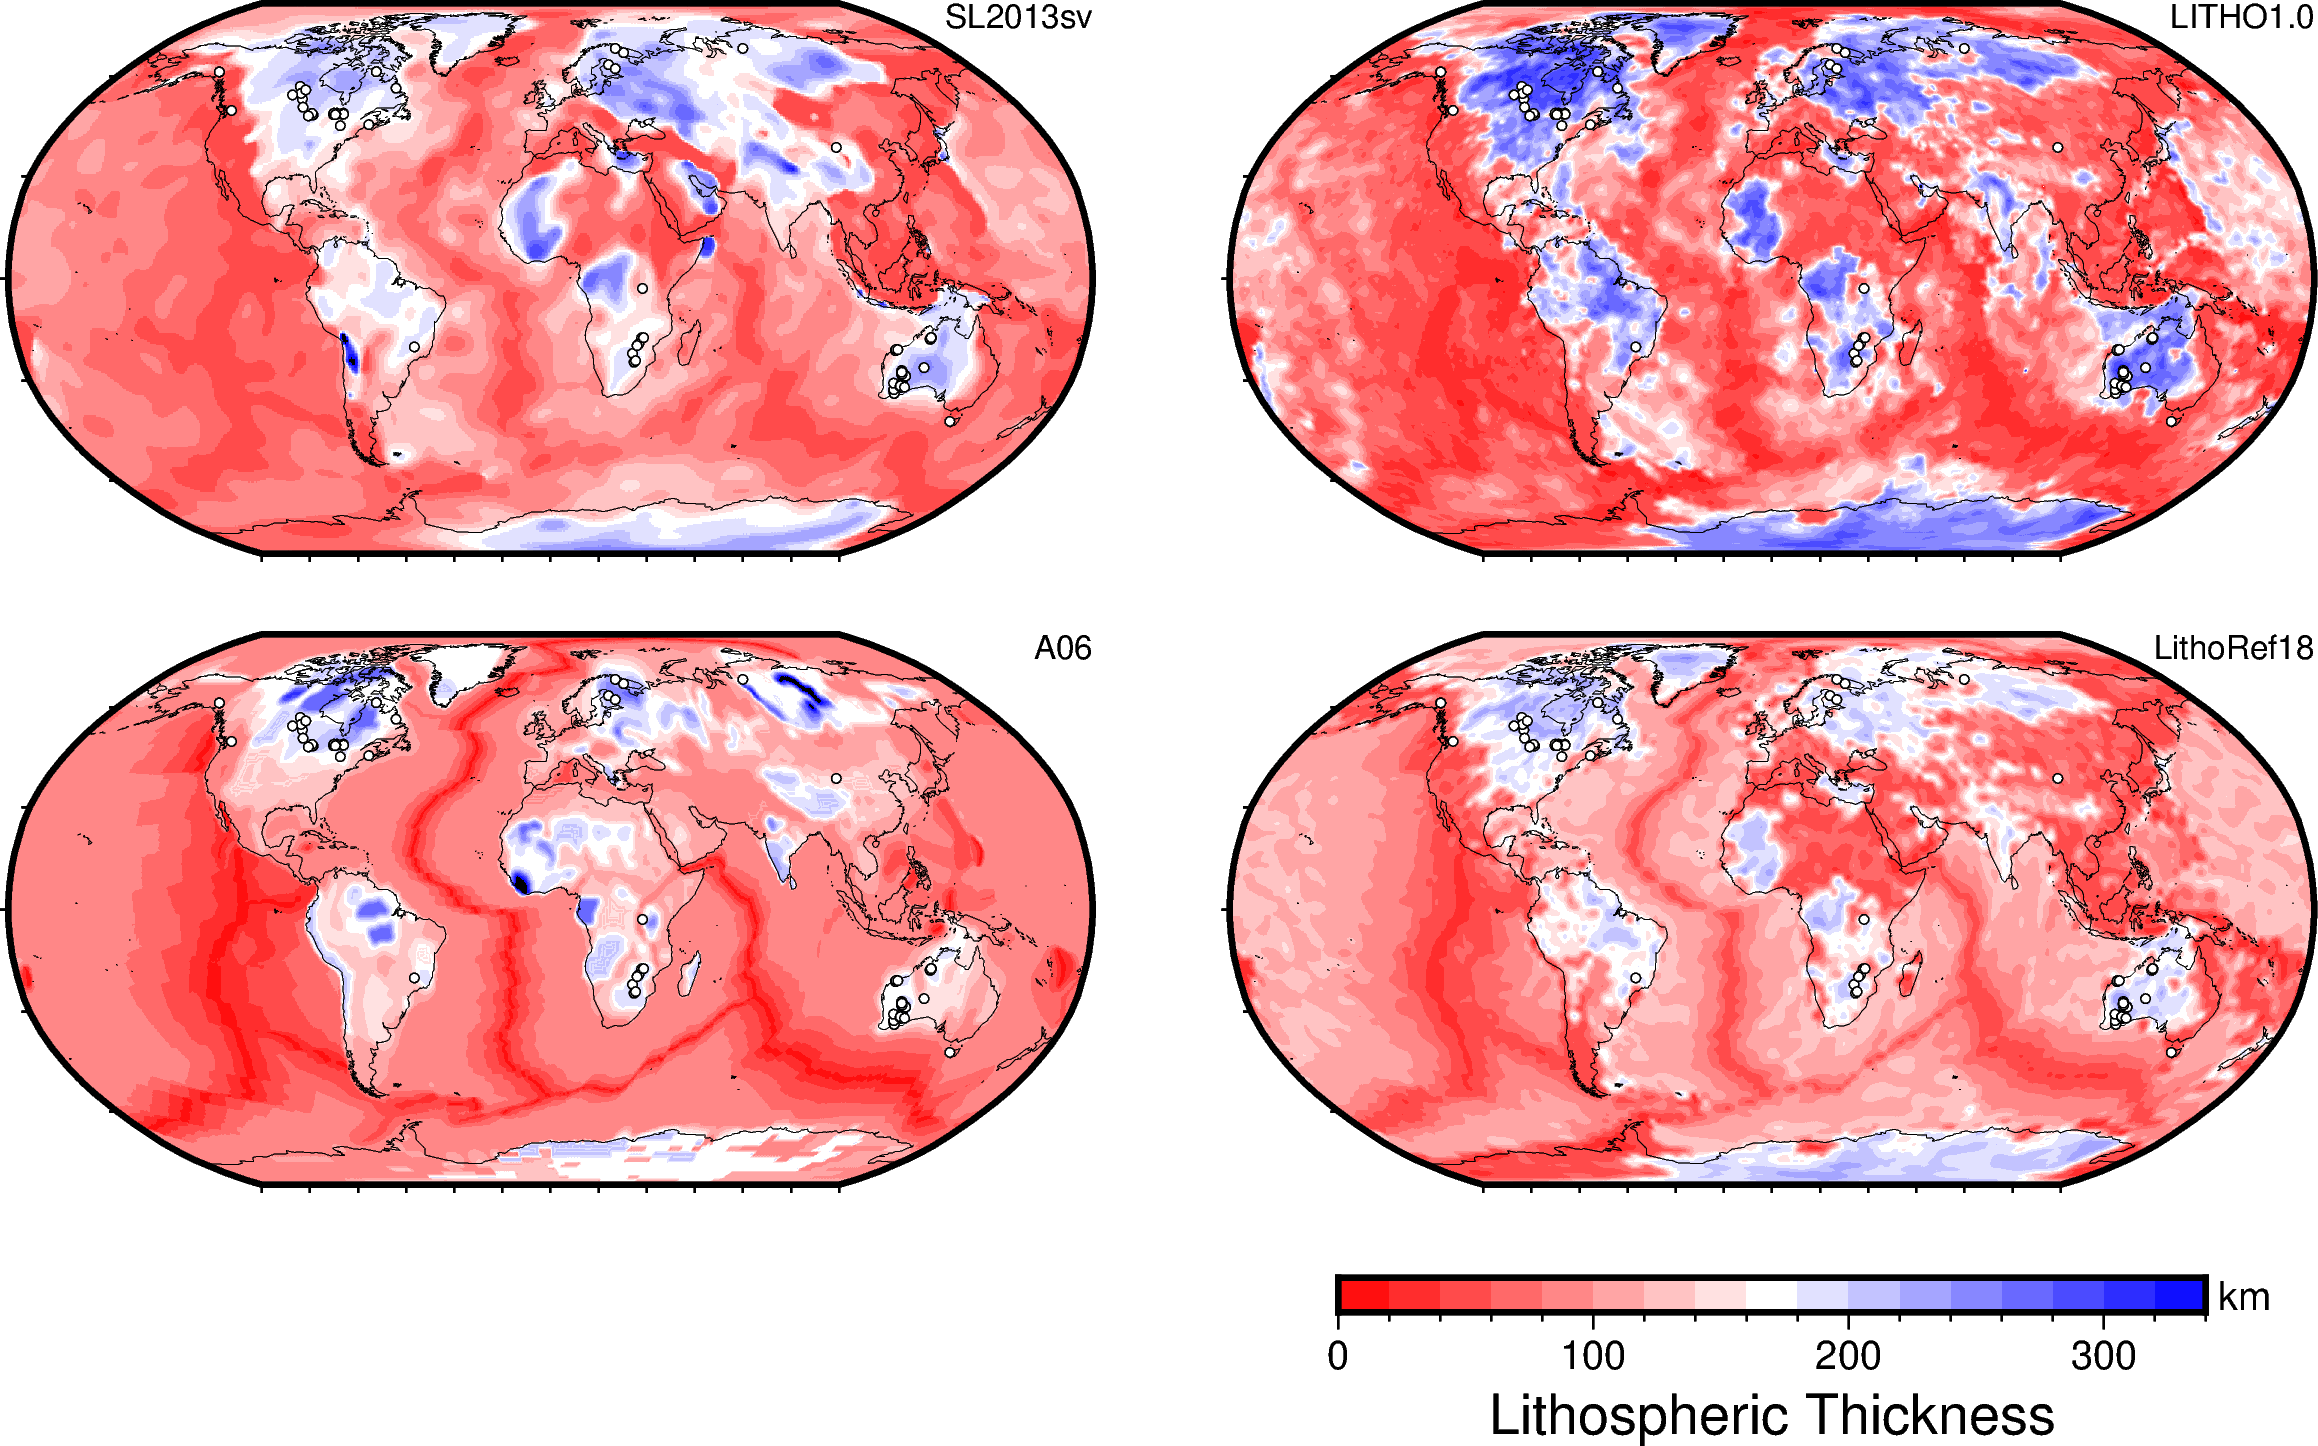

In [52]:
fig = pygmt.Figure()
cmap_series = (0, 350, 20)

with fig.subplot(nrows=2, ncols=2, figsize=("20c", "10c"), margins="0.1c"):

    with fig.set_panel(panel=0):
        pygmt.makecpt(cmap="polar", series=cmap_series, reverse = True)
        fig.grdimage(grid='SL2013sv.nc', projection="N?", frame='f', region = 'd')
        fig.coast(shorelines = "1/0.01,black")
        fig.plot(x=data_mni[..., 0], y=data_mni[..., 1], style="c0.08c", color="white", pen="black")
        fig.text(position="TR", text="SL2013sv", font = "8p")
        
    with fig.set_panel(panel=1):
        pygmt.makecpt(cmap="polar", series=cmap_series, reverse = True)
        fig.grdimage(grid='LAB_litho1.0.grd', projection="N?", frame='f', region = 'd')
        fig.coast(shorelines = "1/0.01,black")
        fig.plot(x=data_mni[..., 0], y=data_mni[..., 1], style="c0.08c", color="white", pen="black")
        fig.text(position="TR", text="LITHO1.0", font = "8p")
        
    with fig.set_panel(panel=2):
        pygmt.makecpt(cmap="polar", series=cmap_series, reverse = True)
        fig.grdimage(grid='A2006_lithosphere.grd', projection="N?", frame='f', region = 'd')
        fig.coast(shorelines = "1/0.01,black")
        fig.plot(x=data_mni[..., 0], y=data_mni[..., 1], style="c0.08c", color="white", pen="black")
        fig.text(position="TR", text="A06", font = "8p")
        
    with fig.set_panel(panel=3):
        pygmt.makecpt(cmap="polar", series=cmap_series, reverse = True)
        fig.grdimage(grid='afonso_2019_LAB_0.25d.grd', projection="N?", frame='f', region = 'd')
        fig.coast(shorelines = "1/0.01,black")
        fig.plot(x=data_mni[..., 0], y=data_mni[..., 1], style="c0.08c", color="white", pen="black")
        fig.text(position="TR", text="LithoRef18", font = "8p")
        fig.colorbar(frame=["x+lLithospheric Thickness", "y+lkm"])

fig.show()
fig.savefig('LAB_maps.jpg')

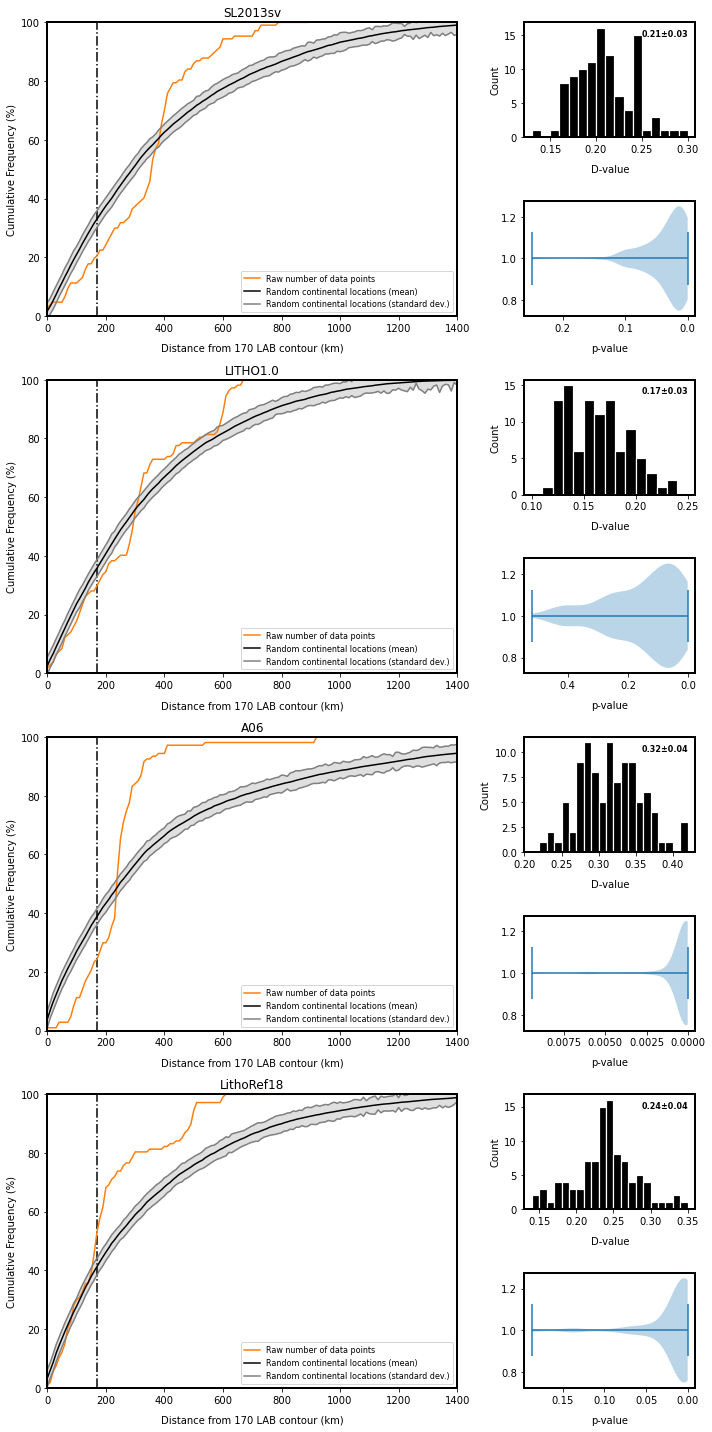

In [55]:
matplotlib.rcParams['axes.linewidth'] = 2
fig = plt.figure(figsize = [10, 20])

ax1 = plt.subplot2grid((8, 3), (0, 0), rowspan = 2, colspan = 2)
plot_cdf(cdf_depositsl13, cdf_randomsl13, std_sl13, ax = ax1, title = "SL2013sv", z = z)

ax2 = fig.add_subplot(833)
plot_hist_d(dsl13, ax2)

ax3 = fig.add_subplot(836)
plot_violin_p(psl13, ax3)

ax4 = plt.subplot2grid((8, 3), (2, 0), rowspan = 2, colspan = 2)
plot_cdf(cdf_depositl1, cdf_randoml1, std_l1, ax = ax4, title = "LITHO1.0", z = z)

ax5 = fig.add_subplot(839)
plot_hist_d(dl1, ax5)

ax6 = fig.add_subplot(8, 3, 12)
plot_violin_p(pl1, ax6)

ax7 = plt.subplot2grid((8, 3), (4, 0), rowspan = 2, colspan = 2)
plot_cdf(cdf_deposita06, cdf_randoma06, std_a06, ax = ax7, title = "A06", z = z)

ax8 = fig.add_subplot(8, 3, 15)
plot_hist_d(da06, ax8)

ax9 = fig.add_subplot(8, 3, 18)
plot_violin_p(pa06, ax9)

ax10 = plt.subplot2grid((8, 3), (6, 0), rowspan = 2, colspan = 2)
plot_cdf(cdf_depositaf, cdf_randomaf, std_af, ax = ax10, title = "LithoRef18", z = z)

ax11 = fig.add_subplot(8, 3, 21)
plot_hist_d(daf, ax11)

ax12 = fig.add_subplot(8, 3, 24)
plot_violin_p(paf, ax12)

fig.tight_layout()
fig.savefig('CDFs.jpg')